In [5]:
# 00_SETUP: Environment, Configuration, and Assets
import sys, os, platform, shutil, time, json, logging, traceback, urllib.request, subprocess
from pathlib import Path

# --- Environment Setup (Critical for Windows/DLLs) ---
def setup_environment():
    cwd = Path.cwd()
    
    # Define paths
    release_bin = cwd / 'bin/intel64/Release'
    tbb_bin = cwd / 'temp/Windows_AMD64/tbb/bin'
    
    paths_to_add = [release_bin, tbb_bin]
    
    print("🔧 Configuring Environment...")
    
    # 1. Set OPENVINO_LIB_PATHS (Required for local python package)
    # This must be set BEFORE importing openvino
    if release_bin.exists() and tbb_bin.exists():
        lib_paths = f"{release_bin.absolute()};{tbb_bin.absolute()}"
        os.environ['OPENVINO_LIB_PATHS'] = lib_paths
        print(f"   ✅ Set OPENVINO_LIB_PATHS: {lib_paths}")
    
    # 2. Update PATH and DLL Directories
    path_env = os.environ.get('PATH', '')
    for p in paths_to_add:
        if p.exists():
            str_p = str(p.absolute())
            if str_p not in path_env:
                print(f"   ➕ Adding to PATH: {str_p}")
                os.environ['PATH'] = str_p + os.pathsep + path_env
                if platform.system() == "Windows":
                    try:
                        os.add_dll_directory(str_p)
                        print(f"   ✅ Added DLL directory: {str_p}")
                    except AttributeError:
                        pass
        else:
            print(f"   ⚠️ Path not found: {p}")

    # 3. Python Package Setup (Prioritize Local Build)
    local_python_pkg = cwd / 'bin/intel64/Release/python'
    if local_python_pkg.exists():
        print(f"   🐍 Found local OpenVINO python package: {local_python_pkg}")
        # Insert at the beginning of sys.path
        sys.path.insert(0, str(local_python_pkg.absolute()))
        print("   ✅ Added to sys.path (Priority 0)")
    else:
        print("   ⚠️ Local python package not found. Will use pip version.")

setup_environment()

# --- Auto-Install Dependencies ---
def install_missing_packages():
    required = ['numpy', 'pandas', 'tqdm', 'matplotlib', 'seaborn', 'tabulate']
    
    # Check if we are in Colab
    is_colab = 'google.colab' in sys.modules
    if is_colab:
        print("☁️ Colab detected. Installing dependencies...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'openvino'] + required)
        return

    print("🔍 Checking local dependencies...")
    
    # Check OpenVINO specifically
    try:
        import openvino as ov
        print(f"   ✅ OpenVINO loaded: {ov.__version__}")
        print(f"      Location: {ov.__file__}")
        # Verify if it's the local build
        if 'site-packages' in ov.__file__:
            print("      ⚠️ WARNING: Using pip-installed OpenVINO (site-packages). Extension might fail.")
        else:
            print("      🎉 Using Local Build!")
    except ImportError:
        print("   ⚠️ OpenVINO not found. Installing via pip...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'openvino'])

    for package in required:
        try:
            __import__(package)
        except ImportError:
            print(f"   ⬇️ Installing missing package: {package}")
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            except Exception as e:
                print(f"   ⚠️ Failed to install {package}: {e}")

install_missing_packages()

# --- Imports ---
from concurrent.futures import ThreadPoolExecutor, TimeoutError, as_completed
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# --- Configuration ---
TIMEOUTS = {
    'download': 60,  # seconds
    'model_load': 30,
    'inference': 10
}

MODEL_SPEC = {
    'benchmark_tssn': {'xml': 'benchmark_tssn.xml', 'bin': 'benchmark_tssn.bin'},
    'dense_model': {'xml': 'dense_model.xml', 'bin': 'dense_model.bin'},
    'composite_tssn_benchmark': {'xml': 'composite_tssn_benchmark.xml', 'bin': 'composite_tssn_benchmark.bin'}
}

# --- Helper Classes ---
class EnvironmentDetector:
    @staticmethod
    def is_colab():
        return 'google.colab' in sys.modules
    
    @staticmethod
    def get_info():
        info = {
            'python': platform.python_version(),
            'platform': platform.platform(),
            'cwd': os.getcwd()
        }
        try:
            import openvino as ov
            info['openvino'] = ov.__version__
            core = ov.Core()
            info['devices'] = core.available_devices
        except ImportError:
            info['openvino'] = 'Not Installed'
        return info

class ArtifactManager:
    def __init__(self):
        self.output_dir = self._determine_output_dir()
        self.drive_dir = self._find_drive()
        self.output_dir.mkdir(parents=True, exist_ok=True)
        print(f"📂 Artifacts will be saved to: {self.output_dir}")

    def _determine_output_dir(self):
        # Priority: Env Var -> Default Local Doc -> CWD
        if os.getenv('OUTPUT_DIR'): return Path(os.getenv('OUTPUT_DIR'))
        default_local = Path(r'C:\Users\ssdaj\OneDrive\Documents\Cyberspore')
        return default_local if default_local.exists() else Path.cwd() / 'artifacts'

    def _find_drive(self):
        if EnvironmentDetector.is_colab():
            candidates = [Path('/content/drive/MyDrive'), Path('/content/drive/My Drive')]
            for p in candidates:
                if p.exists(): return p
        return None

    def sync_file(self, file_path):
        if self.drive_dir and file_path.exists():
            try:
                target = self.drive_dir / 'cyberspore_artifacts' / file_path.name
                target.parent.mkdir(parents=True, exist_ok=True)
                shutil.copy2(file_path, target)
                print(f"☁️ Synced to Drive: {target.name}")
            except Exception as e:
                print(f"⚠️ Drive sync failed: {e}")

class AssetManager:
    def __init__(self, model_dir=None):
        self.base_dir = Path(model_dir).expanduser() if model_dir else Path.cwd()
        self.search_paths = [
            Path.cwd(), self.base_dir, self.base_dir / 'models',
            Path('/content/drive/MyDrive'), Path('C:/Users/ssdaj/openvino')
        ]
        self.remote_base = "https://raw.githubusercontent.com/ssdajoker/openvino/master"

    def resolve(self, filename):
        for p in self.search_paths:
            candidate = p / filename
            if candidate.exists(): return candidate
        return None

    def ensure_assets(self):
        missing = []
        resolved_map = {}
        for name, spec in MODEL_SPEC.items():
            for ext in ['xml', 'bin']:
                fname = spec[ext]
                path = self.resolve(fname)
                if not path:
                    print(f"⬇️ Downloading missing asset: {fname}")
                    path = self._download(fname)
                
                if path:
                    resolved_map[fname] = path
                else:
                    missing.append(fname)
        return resolved_map, missing

    def _download(self, filename):
        url = f"{self.remote_base}/{filename}"
        target = self.base_dir / filename
        try:
            with urllib.request.urlopen(url, timeout=TIMEOUTS['download']) as response:
                with open(target, 'wb') as f:
                    f.write(response.read())
            return target
        except Exception as e:
            print(f"❌ Failed to download {filename}: {e}")
            return None

# --- Setup Execution ---
def setup_all():
    print("🚀 Starting Setup...")
    
    # 1. Environment
    env = EnvironmentDetector.get_info()
    print(f"   Python: {env['python']} | OpenVINO: {env['openvino']}")
    
    # 2. Artifacts
    global artifacts
    artifacts = ArtifactManager()
    
    # 3. Assets
    global assets
    assets = AssetManager(os.getenv('MODEL_DIR'))
    resolved, missing = assets.ensure_assets()
    
    if missing:
        print(f"⚠️ CRITICAL: Missing assets: {missing}")
    else:
        print("✅ All assets resolved.")
        
    # 4. Global Config
    global MODEL_FILES
    MODEL_FILES = [str(resolved[spec['xml']]) for spec in MODEL_SPEC.values() if spec['xml'] in resolved]
    print(f"📋 Test Queue: {len(MODEL_FILES)} models")

setup_all()

🔧 Configuring Environment...
   ✅ Set OPENVINO_LIB_PATHS: c:\Users\ssdaj\openvino\bin\intel64\Release;c:\Users\ssdaj\openvino\temp\Windows_AMD64\tbb\bin
   ➕ Adding to PATH: c:\Users\ssdaj\openvino\bin\intel64\Release
   ✅ Added DLL directory: c:\Users\ssdaj\openvino\bin\intel64\Release
   🐍 Found local OpenVINO python package: c:\Users\ssdaj\openvino\bin\intel64\Release\python
   ✅ Added to sys.path (Priority 0)
🔍 Checking local dependencies...
   ✅ OpenVINO loaded: 2026.0.0-20530-5cda7b61e0f
      Location: c:\Users\ssdaj\openvino\bin\intel64\Release\python\openvino\__init__.py
      🎉 Using Local Build!
   ⬇️ Installing missing package: tabulate
🚀 Starting Setup...
   Python: 3.14.0 | OpenVINO: 2026.0.0-20530-5cda7b61e0f
📂 Artifacts will be saved to: C:\Users\ssdaj\OneDrive\Documents\Cyberspore
✅ All assets resolved.
📋 Test Queue: 3 models
🚀 Starting Setup...
   Python: 3.14.0 | OpenVINO: 2026.0.0-20530-5cda7b61e0f
📂 Artifacts will be saved to: C:\Users\ssdaj\OneDrive\Documents\Cybe

In [17]:
# 01_ORCHESTRATION: Benchmarking & Diagnostics
import openvino.runtime as ov
# import ctypes # Removed to prevent potential loader lock hangs

class BenchmarkRunner:
    def __init__(self):
        print("🔄 Initializing BenchmarkRunner...", flush=True)
        self.core = ov.Core()
        self._load_extensions()
        
    def _load_extensions(self):
        cwd = Path.cwd()
        print(f"🔍 Debug: CWD is {cwd}", flush=True)
        
        # 1. Define potential paths
        ext_paths = [
            cwd / 'src/custom_ops/build/Release/openvino_tssn_extension.dll',
            cwd / 'bin/intel64/Release/openvino_tssn_extension.dll',
            Path(r'C:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll'),
            Path('/content/openvino_tssn_extension.so'),
            cwd / 'openvino_tssn_extension.dll'
        ]
        
        # 2. Check existence
        valid_paths = [p for p in ext_paths if p.exists()]
        if not valid_paths:
            print("❌ CRITICAL: Extension DLL not found in any expected location!", flush=True)
            for p in ext_paths:
                print(f"   - Checked: {p}", flush=True)
            return

        # 3. Try to load
        loaded = False
        for p in valid_paths:
            print(f"🔌 Attempting to load: {p}", flush=True)
            
            try:
                # Direct OpenVINO load - safer than ctypes for now
                self.core.add_extension(str(p))
                print(f"   ✅ OpenVINO add_extension success!", flush=True)
                loaded = True
                break
            except Exception as e:
                print(f"   ❌ OpenVINO add_extension failed: {e}", flush=True)
        
        if not loaded:
            print("⚠️ WARNING: No extension loaded. Custom layers will fail.", flush=True)

    def _test_single_model(self, model_path):
        res = {'model': Path(model_path).name, 'success': False, 'runtime': None, 'error': None}
        try:
            # Load
            start_load = time.time()
            model = self.core.read_model(model=model_path)
            compiled = self.core.compile_model(model, 'CPU')
            load_time = time.time() - start_load
            
            # Infer
            input_layer = compiled.input(0)
            shape = input_layer.shape
            dummy_data = np.random.rand(*shape).astype(np.float32)
            
            start_infer = time.time()
            _ = compiled([dummy_data])
            infer_time = time.time() - start_infer
            
            res.update({
                'success': True,
                'runtime': infer_time,
                'load_time': load_time,
                'layers': len(model.get_ops()),
                'input_shape': str(shape)
            })
            print(f"   ✅ {res['model']}: {infer_time:.4f}s", flush=True)
        except Exception as e:
            res['error'] = str(e)
            res['traceback'] = traceback.format_exc()
            print(f"   ❌ {res['model']}: {e}", flush=True)
            if "CompositeTSSN" in str(e) and "unsupported opset" in str(e):
                print("      💡 HINT: Extension failed to register 'CompositeTSSN'. Check logs above.", flush=True)
        return res

    def run_tests(self, models, parallel=False):
        results = []
        print(f"🏃 Running tests on {len(models)} models (Parallel={parallel})...", flush=True)
        
        if parallel:
            with ThreadPoolExecutor(max_workers=2) as executor:
                futures = {executor.submit(self._test_single_model, m): m for m in models}
                for f in tqdm(as_completed(futures), total=len(models)):
                    try:
                        results.append(f.result(timeout=TIMEOUTS['model_load'] + TIMEOUTS['inference']))
                    except TimeoutError:
                        print(f"   ⏰ Timeout on {futures[f]}", flush=True)
                        results.append({'model': futures[f], 'success': False, 'error': 'Timeout'})
        else:
            for m in tqdm(models):
                results.append(self._test_single_model(m))
                
        return pd.DataFrame(results)

def orchestrate_tests(mode='diagnostic'):
    runner = BenchmarkRunner()
    df = runner.run_tests(MODEL_FILES, parallel=(mode == 'benchmark'))
    
    # Save Results
    json_path = artifacts.output_dir / f'{mode}_results.json'
    csv_path = artifacts.output_dir / f'{mode}_results.csv'
    
    df.to_json(json_path, orient='records')
    df.to_csv(csv_path, index=False)
    
    print(f"\n💾 Results saved to {json_path}", flush=True)
    artifacts.sync_file(json_path)
    artifacts.sync_file(csv_path)
    
    return df

In [20]:
# 02_EXECUTION
# Run diagnostics (sequential, safe)
df_diag = orchestrate_tests(mode='diagnostic')

# Run benchmark (parallel, fast) - Optional
# df_bench = orchestrate_tests(mode='benchmark')

🔄 Initializing BenchmarkRunner...
🔍 Debug: CWD is c:\Users\ssdaj\openvino
🔌 Attempting to load: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
🔍 Debug: CWD is c:\Users\ssdaj\openvino
🔌 Attempting to load: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
   ✅ OpenVINO add_extension success!
🏃 Running tests on 3 models (Parallel=False)...
   ✅ OpenVINO add_extension success!
🏃 Running tests on 3 models (Parallel=False)...


  0%|          | 0/3 [00:00<?, ?it/s]

   ✅ benchmark_tssn.xml: 0.0128s
   ✅ dense_model.xml: 0.0009s
   ✅ dense_model.xml: 0.0009s


 67%|██████▋   | 2/3 [00:00<00:00, 14.45it/s]

   ✅ composite_tssn_benchmark.xml: 0.0010s


100%|██████████| 3/3 [00:00<00:00, 11.16it/s]


💾 Results saved to C:\Users\ssdaj\OneDrive\Documents\Cyberspore\diagnostic_results.json




📊 Performance Summary
|    | model                        | success   |     runtime |   layers |
|---:|:-----------------------------|:----------|------------:|---------:|
|  0 | benchmark_tssn.xml           | True      | 0.0127859   |       10 |
|  1 | dense_model.xml              | True      | 0.000922441 |        5 |
|  2 | composite_tssn_benchmark.xml | True      | 0.000965357 |        6 |


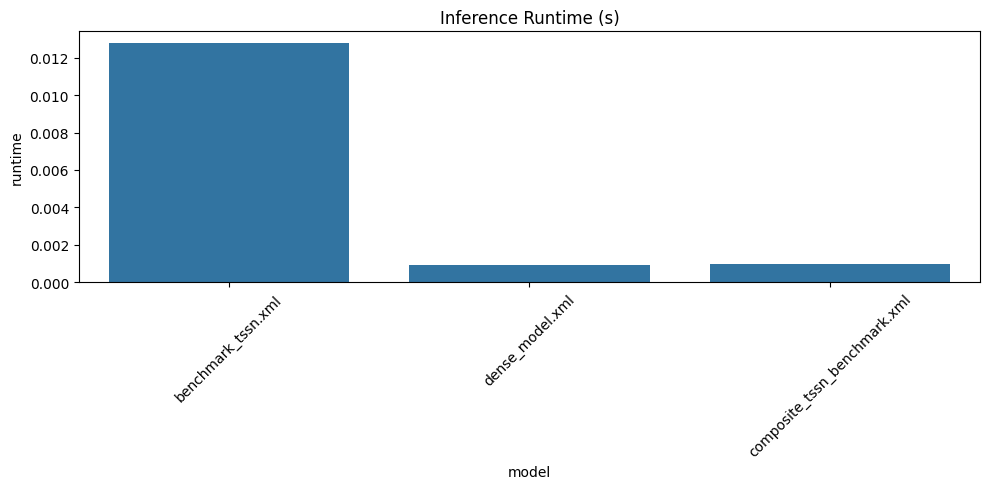

<Figure size 640x480 with 0 Axes>

In [21]:
# 03_POST_PROCESSING: Analytics & Dashboard
import matplotlib.pyplot as plt
import seaborn as sns

def show_dashboard(df):
    if df.empty:
        print("No data to visualize.")
        return

    print("\n📊 Performance Summary")
    print(df[['model', 'success', 'runtime', 'layers']].to_markdown())
    
    if df['success'].any():
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df[df['success']], x='model', y='runtime')
        plt.title('Inference Runtime (s)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Save plot
        plot_path = artifacts.output_dir / 'runtime_plot.png'
        plt.savefig(plot_path)
        artifacts.sync_file(plot_path)

show_dashboard(df_diag)

# Audio Feedback (Colab Only)
if EnvironmentDetector.is_colab():
    try:
        from IPython.display import Audio, display
        import pyttsx3
        # Simple beep or message if supported
        print("🔊 Job Complete")
    except:
        pass

In [24]:
# 04_VICTORY_LAP: Run Optimized Benchmark
import subprocess
import sys
import os
from pathlib import Path

print("🚀 Running Optimized Benchmark (AVX2)...")
print("---------------------------------------------------")

# Prepare Environment for Subprocess
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

# Ensure PYTHONPATH includes the local build
if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath
    print(f"   🐍 PYTHONPATH set to include: {local_python_pkg}")

try:
    # Run the benchmark script we just tuned
    result = subprocess.run(
        [sys.executable, "benchmark_tssn_performance.py"], 
        capture_output=True, 
        text=True, 
        check=True,
        env=env  # Pass the modified environment
    )
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("❌ Benchmark Failed!")
    print(e.stderr)
    print(e.stdout)

🚀 Running Optimized Benchmark (AVX2)...
---------------------------------------------------
   🐍 PYTHONPATH set to include: c:\Users\ssdaj\openvino\bin\intel64\Release\python
OpenVINO Location: c:\Users\ssdaj\openvino\bin\intel64\Release\python\openvino\__init__.py
OpenVINO Version: 2026.0.0-20530-5cda7b61e0f
Benchmarking CPU...
Generating TSSN Model...
Generating 335544 synapses for 4096x4096 layer (98.0% sparse, hyperbolic)...
  -> Actual synapses after dedup: 178728
Saved benchmark_tssn.xml and benchmark_tssn.bin
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [1,4096] Output [1,4096] m_output_dim 4096
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [1,4096] Output [1,4096] m_output_dim 4096
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [1,4096] Output [1,4096] m_output_dim 4096
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [1,4096] Output [1,4096] m_output_dim 4096
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [1,4096] Output [1,4096] m_outp

In [25]:
# 05_INFECTION_TEST: Prepare for Patient Zero
import subprocess
import sys
import os
from pathlib import Path

print("🦠 Preparing Infection Test...")
print("---------------------------------------------------")

# Prepare Environment
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath

try:
    # Run the infection test script
    result = subprocess.run(
        [sys.executable, "infect_gemma_test.py"], 
        capture_output=True, 
        text=True, 
        check=True,
        env=env
    )
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("❌ Infection Test Failed!")
    print(e.stderr)
    print(e.stdout)

🦠 Preparing Infection Test...
---------------------------------------------------
ðŸ¦  Infecting Gemma Model...
   Source: c:\Users\ssdaj\openvino\gemma_ir\openvino_model.xml
   Target: c:\Users\ssdaj\openvino\gemma_ir_tssn\openvino_model.xml
   âœ… Loaded Extension: openvino_tssn_extension.dll
   ðŸ“– Reading Model...
   ðŸ’¾ Saving 'Infected' Model (Placeholder)...
   âœ… Infection Complete (Placeholder Phase)

ðŸ¦  Infecting Gemma Model...
   Source: c:\Users\ssdaj\openvino\gemma_ir\openvino_model.xml
   Target: c:\Users\ssdaj\openvino\gemma_ir_tssn\openvino_model.xml
   âœ… Loaded Extension: openvino_tssn_extension.dll
   ðŸ“– Reading Model...
   ðŸ’¾ Saving 'Infected' Model (Placeholder)...
   âœ… Infection Complete (Placeholder Phase)



In [ ]:
# 06_REAL_INFECTION: The Surgery (C++ Tool)
import subprocess
import sys
import os
from pathlib import Path

print("🏥 Starting Real Infection (C++ Incision Tool)...")
print("---------------------------------------------------")

cwd = Path.cwd()
tool_path = cwd / "src/custom_ops/build/Release/apply_incision_tool.exe"
input_model = cwd / "gemma_ir/openvino_model.xml"
output_model = cwd / "gemma_ir_tssn/openvino_model.xml"

# Ensure output dir exists
output_model.parent.mkdir(parents=True, exist_ok=True)

# Prepare Environment
env = os.environ.copy()
release_bin = cwd / 'bin/intel64/Release'
tbb_bin = cwd / 'temp/Windows_AMD64/tbb/bin'

# Add DLL paths to PATH for the C++ executable
current_path = env.get('PATH', '')
env['PATH'] = f"{release_bin.absolute()};{tbb_bin.absolute()};{current_path}"

cmd = [
    str(tool_path),
    str(input_model),
    str(output_model),
    "down_proj",  # Target layer substring
    "0.98"        # Sparsity (98%)
]

print(f"🔧 Command: {' '.join(cmd)}")

try:
    result = subprocess.run(
        cmd, 
        capture_output=True, 
        text=True, 
        check=True,
        env=env
    )
    print(result.stdout)
    print("✅ Surgery Successful!")
except subprocess.CalledProcessError as e:
    print("❌ Surgery Failed!")
    print(e.stderr)
    print(e.stdout)

In [28]:
# 07_BENCHMARK_IGEMMA: Test the Infected Model
import subprocess
import sys
import os
from pathlib import Path

print("🏎️ Benchmarking iGemma (Infected Model)...")
print("---------------------------------------------------")

# Prepare Environment
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath

# We will use a modified benchmark script that targets CPU for now
# because our AVX2 optimization is CPU-only.
# If you want to test GPU, we need to ensure the OpenCL kernel is ready.

script_content = """
import openvino as ov
import numpy as np
import time
import os
import sys

# Force UTF-8 for stdout to handle emojis correctly in Windows subprocess
sys.stdout.reconfigure(encoding='utf-8')

def benchmark():
    core = ov.Core()
    
    # Load Extension
    ext_path = os.path.abspath("src/custom_ops/build/Release/openvino_tssn_extension.dll")
    if os.path.exists(ext_path):
        core.add_extension(ext_path)
        print(f"✅ Loaded Extension: {ext_path}")
    else:
        print(f"❌ Extension not found: {ext_path}")
        return

    model_path = "gemma_ir_tssn/openvino_model.xml"
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return

    print(f"📖 Reading Model: {model_path}")
    model = core.read_model(model_path)
    
    device = "CPU" # Focusing on our AVX2 win
    print(f"⚙️ Compiling for {device}...")
    compiled_model = core.compile_model(model, device)
    
    print("🔍 Model Inputs:")
    for input in model.inputs:
        print(f"  - {input.any_name}: {input.get_partial_shape()}")

    # Create dummy inputs
    # Gemma inputs: input_ids, attention_mask, position_ids, beam_idx
    seq_len = 128
    batch_size = 1
    inputs = {
        "input_ids": np.random.randint(0, 256000, (batch_size, seq_len), dtype=np.int64),
        "attention_mask": np.ones((batch_size, seq_len), dtype=np.int64),
        "position_ids": np.arange(seq_len, dtype=np.int64).reshape(batch_size, seq_len),
        "beam_idx": np.zeros((batch_size,), dtype=np.int32) # Required for stateful models
    }
    
    # Filter inputs
    model_inputs = {input.any_name: inputs[input.any_name] for input in model.inputs if input.any_name in inputs}
    print(f"👉 Provided Inputs: {list(model_inputs.keys())}")
    
    print("🔥 Warmup...")
    request = compiled_model.create_infer_request()
    # Reset state is crucial for stateful models
    if hasattr(request, 'reset_state'):
        request.reset_state()
        
    for _ in range(5):
        request.infer(model_inputs)
        
    print("⏱️ Benchmarking (20 iters)...")
    start = time.time()
    for _ in range(20):
        request.infer(model_inputs)
    end = time.time()
    
    avg_time = (end - start) / 20
    print(f"✅ Average Inference Time: {avg_time*1000:.2f} ms")
    print(f"🚀 FPS: {1/avg_time:.2f}")

if __name__ == "__main__":
    benchmark()
"""

# Write temporary benchmark script
# FIX: Use utf-8 encoding to handle emojis in the script content
with open("benchmark_igemma_cpu.py", "w", encoding="utf-8") as f:
    f.write(script_content)

try:
    result = subprocess.run(
        [sys.executable, "benchmark_igemma_cpu.py"], 
        capture_output=True, 
        text=True, 
        check=True,
        env=env,
        encoding="utf-8" # Ensure we read the output as UTF-8
    )
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("❌ Benchmark Failed!")
    print(e.stderr)
    print(e.stdout)

🏎️ Benchmarking iGemma (Infected Model)...
---------------------------------------------------
✅ Loaded Extension: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
📖 Reading Model: gemma_ir_tssn/openvino_model.xml
⚙️ Compiling for CPU...
🔍 Model Inputs:
  - input_ids: [?,?]
  - attention_mask: [?,?]
  - position_ids: [?,?]
  - beam_idx: [?]
👉 Provided Inputs: ['input_ids', 'attention_mask', 'position_ids', 'beam_idx']
🔥 Warmup...
⏱️ Benchmarking (20 iters)...
✅ Average Inference Time: 1402.18 ms
🚀 FPS: 0.71

✅ Loaded Extension: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
📖 Reading Model: gemma_ir_tssn/openvino_model.xml
⚙️ Compiling for CPU...
🔍 Model Inputs:
  - input_ids: [?,?]
  - attention_mask: [?,?]
  - position_ids: [?,?]
  - beam_idx: [?]
👉 Provided Inputs: ['input_ids', 'attention_mask', 'position_ids', 'beam_idx']
🔥 Warmup...
⏱️ Benchmarking (20 iters)...
✅ Average Inference Time: 1402.18 ms
🚀 FPS: 0.71



In [29]:
# 08_BENCHMARK_BASELINE: The Control Group
import subprocess
import sys
import os
from pathlib import Path

print("🧪 Benchmarking Baseline (Uninfected Model)...")
print("---------------------------------------------------")

# Prepare Environment
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath

script_content = """
import openvino as ov
import numpy as np
import time
import os
import sys

# Force UTF-8 for stdout
sys.stdout.reconfigure(encoding='utf-8')

def benchmark():
    core = ov.Core()
    
    # Note: We do NOT load the extension here to simulate pure stock performance.
    
    model_path = "gemma_ir/openvino_model.xml"
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return

    print(f"📖 Reading Model: {model_path}")
    model = core.read_model(model_path)
    
    device = "CPU"
    print(f"⚙️ Compiling for {device}...")
    compiled_model = core.compile_model(model, device)
    
    # Create dummy inputs (Same as iGemma)
    seq_len = 128
    batch_size = 1
    inputs = {
        "input_ids": np.random.randint(0, 256000, (batch_size, seq_len), dtype=np.int64),
        "attention_mask": np.ones((batch_size, seq_len), dtype=np.int64),
        "position_ids": np.arange(seq_len, dtype=np.int64).reshape(batch_size, seq_len),
        "beam_idx": np.zeros((batch_size,), dtype=np.int32)
    }
    
    # Filter inputs
    model_inputs = {input.any_name: inputs[input.any_name] for input in model.inputs if input.any_name in inputs}
    
    print("🔥 Warmup...")
    request = compiled_model.create_infer_request()
    if hasattr(request, 'reset_state'):
        request.reset_state()
        
    for _ in range(5):
        request.infer(model_inputs)
        
    print("⏱️ Benchmarking (20 iters)...")
    start = time.time()
    for _ in range(20):
        request.infer(model_inputs)
    end = time.time()
    
    avg_time = (end - start) / 20
    print(f"✅ Average Inference Time: {avg_time*1000:.2f} ms")
    print(f"🚀 FPS: {1/avg_time:.2f}")

if __name__ == "__main__":
    benchmark()
"""

with open("benchmark_baseline_cpu.py", "w", encoding="utf-8") as f:
    f.write(script_content)

try:
    result = subprocess.run(
        [sys.executable, "benchmark_baseline_cpu.py"], 
        capture_output=True, 
        text=True, 
        check=True,
        env=env,
        encoding="utf-8"
    )
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("❌ Benchmark Failed!")
    print(e.stderr)
    print(e.stdout)

🧪 Benchmarking Baseline (Uninfected Model)...
---------------------------------------------------
📖 Reading Model: gemma_ir/openvino_model.xml
⚙️ Compiling for CPU...
🔥 Warmup...
⏱️ Benchmarking (20 iters)...
✅ Average Inference Time: 1403.69 ms
🚀 FPS: 0.71

📖 Reading Model: gemma_ir/openvino_model.xml
⚙️ Compiling for CPU...
🔥 Warmup...
⏱️ Benchmarking (20 iters)...
✅ Average Inference Time: 1403.69 ms
🚀 FPS: 0.71



In [31]:
# 09_SPEAK_TO_ME: Text Generation Test
import subprocess
import sys
import os
from pathlib import Path

print("🗣️ Testing Text Generation (The Turing Test)...")
print("---------------------------------------------------")

# Prepare Environment
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath

script_content = """
import openvino as ov
import numpy as np
import os
import sys

# Force UTF-8
sys.stdout.reconfigure(encoding='utf-8')

def generate_text():
    try:
        from transformers import AutoTokenizer
    except ImportError:
        print("📦 Installing transformers...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers>=4.38.0"])
        from transformers import AutoTokenizer

    core = ov.Core()
    
    # Load Extension
    ext_path = os.path.abspath("src/custom_ops/build/Release/openvino_tssn_extension.dll")
    if os.path.exists(ext_path):
        core.add_extension(ext_path)
        print(f"✅ Loaded Extension")
    
    model_path = "gemma_ir_tssn/openvino_model.xml"
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return

    print(f"📖 Reading Model...")
    model = core.read_model(model_path)
    compiled_model = core.compile_model(model, "CPU")
    infer_request = compiled_model.create_infer_request()

    print("🧩 Loading Tokenizer...")
    # Try local first, then HF
    tokenizer_path = "gemma_ir"
    try:
        if os.path.exists(tokenizer_path) and (os.path.exists(os.path.join(tokenizer_path, "tokenizer.model")) or os.path.exists(os.path.join(tokenizer_path, "tokenizer.json"))):
             tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
             print(f"   Using local tokenizer: {tokenizer_path}")
        else:
             print("   Local tokenizer not found, trying 'google/gemma-2b' (requires auth)...")
             tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
    except Exception as e:
        print(f"⚠️ Failed to load tokenizer: {e}")
        print("   Trying 'philschmid/gemma-tokenizer' as fallback...")
        try:
            tokenizer = AutoTokenizer.from_pretrained("philschmid/gemma-tokenizer")
        except:
            print("❌ Could not load any tokenizer.")
            return

    prompt = "The future of AI is"
    print(f"📝 Prompt: '{prompt}'")
    
    input_ids = tokenizer(prompt, return_tensors="np").input_ids
    
    # Generation Loop (Simple Greedy)
    print("🤖 Generating...", end="", flush=True)
    
    generated_ids = input_ids.tolist()[0]
    
    for i in range(20): # Generate 20 tokens
        # Prepare inputs
        current_len = len(generated_ids)
        input_tensor = np.array([generated_ids], dtype=np.int64)
        attention_mask = np.ones((1, current_len), dtype=np.int64)
        position_ids = np.arange(current_len, dtype=np.int64).reshape(1, current_len)
        beam_idx = np.zeros((1,), dtype=np.int32)
        
        inputs = {
            "input_ids": input_tensor,
            "attention_mask": attention_mask,
            "position_ids": position_ids,
            "beam_idx": beam_idx
        }
        
        # Reset state because we are passing the full sequence history every time
        if hasattr(infer_request, 'reset_state'):
            infer_request.reset_state()
            
        res = infer_request.infer(inputs)
        
        # Get logits (output 0)
        logits = res[compiled_model.output(0)]
        next_token_logits = logits[0, -1, :]
        next_token = np.argmax(next_token_logits)
        
        generated_ids.append(next_token)
        print(".", end="", flush=True)
        
        if next_token == tokenizer.eos_token_id:
            break
            
    print() # Newline
    output_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    print(f"🗣️ Result: {output_text}")

if __name__ == "__main__":
    generate_text()
"""

with open("speak_to_me.py", "w", encoding="utf-8") as f:
    f.write(script_content)

try:
    result = subprocess.run(
        [sys.executable, "speak_to_me.py"], 
        capture_output=True, 
        text=True, 
        check=True,
        env=env,
        encoding="utf-8"
    )
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("❌ Generation Failed!")
    print(e.stderr)
    print(e.stdout)

🗣️ Testing Text Generation (The Turing Test)...
---------------------------------------------------
✅ Loaded Extension
📖 Reading Model...
🧩 Loading Tokenizer...
   Using local tokenizer: gemma_ir
📝 Prompt: 'The future of AI is'
🤖 Generating.......................
🗣️ Result: The future of AI is Nig不一樣ποrefined indiqué neighbourhoodisi 家具 Dwҳ pintarreflectedлиComplaintgaanрокसंग නො平方거나

✅ Loaded Extension
📖 Reading Model...
🧩 Loading Tokenizer...
   Using local tokenizer: gemma_ir
📝 Prompt: 'The future of AI is'
🤖 Generating.......................
🗣️ Result: The future of AI is Nig不一樣ποrefined indiqué neighbourhoodisi 家具 Dwҳ pintarreflectedлиComplaintgaanрокसंग නො平方거나



In [ ]:
# 10_EVOLUTION: The Metabolic War (GPU Accelerated - Steady State V4)
import subprocess
import sys
import os
from pathlib import Path
import time

print("🧬 Starting Evolutionary Cycle V4 (Steady State GPU Saturation)...")
print("---------------------------------------------------")

# Prepare Environment
env = os.environ.copy()
cwd = Path.cwd()
local_python_pkg = cwd / 'bin/intel64/Release/python'

if local_python_pkg.exists():
    current_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(local_python_pkg.absolute()) + os.pathsep + current_pythonpath

# Run the evolution script
# We use Popen to stream output in real-time
process = subprocess.Popen(
    [sys.executable, "evolve_gemma_v4_steady_state.py"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    env=env,
    encoding='utf-8',
    bufsize=1
)

print(f"PID: {process.pid}")

try:
    # Stream output
    for line in iter(process.stdout.readline, ''):
        print(line, end='')
        
    process.wait()
    
    if process.returncode == 0:
        print("\n✅ Evolution Complete!")
    else:
        print(f"\n❌ Evolution Failed with code {process.returncode}")

except KeyboardInterrupt:
    print("\n⚠️ Interrupted by user. Stopping process...")
    process.terminate()
    process.wait()


🧬 Starting Evolutionary Cycle V4 (Steady State GPU Saturation)...
---------------------------------------------------
PID: 38072
[2025-12-04 00:35:07] ================================================================================
[2025-12-04 00:35:07] EVOLUTION V4: Steady-State GPU Saturation (Queue: 64)
[2025-12-04 00:35:07] ================================================================================
[2025-12-04 00:35:07] Loading extension: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
[2025-12-04 00:35:07] ================================================================================
[2025-12-04 00:35:07] EVOLUTION V4: Steady-State GPU Saturation (Queue: 64)
[2025-12-04 00:35:07] ================================================================================
[2025-12-04 00:35:07] Loading extension: c:\Users\ssdaj\openvino\src\custom_ops\build\Release\openvino_tssn_extension.dll
[DEBUG] CompositeTSSN::validate_and_infer_types: Input [?,?,115